In [1]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import numpy as np
import h5py

import json
import pickle

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"device {device}")
torch.manual_seed(0)

device cuda:2


### Dataset class

In [4]:
def encode_one_hot(input_label : torch.tensor):
    """
    expect tensor with two values 
    """
    if input_label == 0:
        return torch.tensor([1,0], dtype=torch.int64)
    elif input_label == 1:
        return torch.tensor([0,1], dtype=torch.int64)
    else:
        raise Exception("error in encode_one_hot, unexpected value")

class alc_dataset(Dataset):
    def __init__(self, file, has_label=True):
        self.signals = []
        self.labels = []
        self.one_hot_labels = []
        self.max_length = 0
        self.transform = None
        self.has_label = has_label
        self.filename = file 

        with h5py.File(self.filename, "r") as h5_file:
            self.number_datasets = h5_file["number_datasets"].astype(int)[()]
        
        return

        with open(file, 'r') as f:
            data = json.load(f)
        values = list(data.values())
        for value in values:
            feature = value['features']
            if has_label:
                label = int(value['label'])
                label_one_hot = encode_one_hot(torch.tensor(label))
                self.labels.append(label)
                self.one_hot_labels.append(label_one_hot)
            
            if len(feature) > self.max_length:
                self.max_length = len(feature)

            self.signals.append(feature)
    def __len__(self):
        return self.number_datasets
    
    def get_max_length(self):
        """
        get maximum lengths of all features in dataset
        """
        max_length = 0
        with h5py.File(self.filename, "r") as h5_file:
            for idx in range(self.number_datasets):
                dataset_group = h5_file[f"dataset_{idx:07d}"]
                features = np.array(dataset_group.get("features"))
                max_length = max(features.shape[1], max_length)

        return max_length
    
    def __getitem__(self, idx):

        with h5py.File(self.filename, "r") as h5_file:
            dataset_group = h5_file[f"dataset_{idx:07d}"]
            label = dataset_group.get("label").astype(int)[()]
            label_one_hot = encode_one_hot(torch.tensor(label))
            features = np.array(dataset_group.get("features"))
        
        if self.transform is None:
            x = torch.tensor(features, dtype=torch.float32)
        else:
            x = self.transform(torch.tensor(features, dtype=torch.float32), self.max_length)

        if self.has_label:
            return x, torch.tensor(label).to(device), torch.tensor(label_one_hot).to(device)
        else:
            return x

### CNN model

In [5]:
class ModelSkip(nn.Module):
   def __init__(self):
      #,number_features, time_length=1707):
      super(ModelSkip, self).__init__()

      self.adapt_max_pool = nn.AdaptiveMaxPool2d((6, 40))
      
      self.enc_cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size= (5,5))
      self.enc_cnn2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size= (5,5), stride=2)
      self.enc_cnn3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size= (5,5))
      self.enc_cnn4 = nn.Conv2d(in_channels=48, out_channels=16, kernel_size= (5,5), stride=2)

      self.skip_cnn = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(5,5), stride=2)

      #128, 4, 119
      self.linear_1 = nn.Linear(3840 , 128)
      self.linear_2 = nn.Linear(128, 64)
      self.linear_out = nn.Linear(64, 2)

      self.relu1 = nn.ReLU()
      self.relu2 = nn.ReLU()
      self.relu3 = nn.ReLU()
      self.relu4 = nn.ReLU()
      self.relu5 = nn.ReLU()
      self.relu6 = nn.ReLU()

      self.dropout1 = nn.Dropout(0.6)
      self.dropout2 = nn.Dropout(0.6)
      self.batch_norm1 = nn.BatchNorm2d(32)
      self.batch_norm2 = nn.BatchNorm2d(32)
      self.batch_norm3 = nn.BatchNorm2d(32)
      self.batch_norm4 = nn.BatchNorm2d(16)

   def forward(self, x):

      # actual zero padded data
      x_in_data = x[0]

      # data length of each element in batch
      x_lengths = x[1]
      max_length = max(x_lengths)
      
      # crop to max length in batch
      x_in_data = x_in_data[:, :max_length]
      
      x2 = self.enc_cnn1(x_in_data)
      x3 = self.batch_norm1(x2)
      x4 = self.relu1(x3)

      
      x_skip = self.skip_cnn(x4)
      #print(f"x_skip: {x_skip.shape}")
      #print(f"x4: {x4.shape}")

      x5 = self.enc_cnn2(x4)
      x6 = self.batch_norm2(x5)
      x7 = self.relu2(x6)
      #x7 = self.dropout3(x7)
      #print(f"x7: {x7.shape}")

      x8 = self.enc_cnn3(x7)
      x9 = self.batch_norm3(x8)
      x10 = self.relu3(x9)
      #x10 = self.dropout4(x10)
      #print(f"x10: {x10.shape}")
      x_comp =torch.concat((x_skip[:, :, :x10.shape[2], :x10.shape[3]], x10), dim=1)
      #print(f"x_com: {x_comp.shape}")

      x11 = self.enc_cnn4(x_comp)
      x12 = self.batch_norm4(x11)
      x13 = self.relu4(x12)

      x13 = self.adapt_max_pool(x13)
      #print(f"x13: {x13.shape}")

      #print(f"x10: {x10.shape}")    
      x14 = x13.view((x13.shape[0], -1))

      
      x15 = self.linear_1(x14)
      x15 = self.relu5(x15)
      x15 = self.dropout1(x15)

      x16 = self.linear_2(x15)
      x16 = self.relu6(x16)
      x16 = self.dropout2(x16)

      x_out = self.linear_out(x16)
      return x_out

### Some padding functions

In [6]:
def input_flexibel_padding(input, len_type):
   input = torch.unsqueeze(input, 0)
   input = torch.unsqueeze(input, 0)
   padded_input = torch.nn.functional.interpolate(input, (input.shape[2], len_type))
   padded_input = torch.squeeze(padded_input, 0)
   return padded_input
def input_zero_padding(input, len_type):
   padded_input = torch.zeros((input.shape[0], len_type), dtype=torch.float32)
   if input.shape[1] <= len_type:
      padded_input[:,:input.shape[1]] = input
   else:
      padded_input = input[:,:len_type]
   padded_input = torch.unsqueeze(padded_input, 0)
   return padded_input

def input_zero_padding_with_length(input, len_type):
   """
   Does zero padding and at the same also returns the length of the data 
   """
   padded_input = torch.zeros((input.shape[0], len_type), dtype=torch.float32)
   
   if input.shape[1] <= len_type:
      padded_input[:,:input.shape[1]] = input
   else:
      padded_input = input[:,:len_type]
   padded_input = torch.unsqueeze(padded_input, 0)
   return padded_input, input.shape[1]

def input_flexibel_padding_resnet(input, len_type):
   input_width = 230
   padded_input = torch.zeros((input_width, len_type), dtype=torch.float32)

   if input.shape[1] <= len_type:
      padded_input[:input.shape[0],:input.shape[1]] = input
   else:
      padded_input[:input.shape[0],:] = input[:,:len_type]
   padded_input = torch.unsqueeze(padded_input, dim=0)
   padded_input = padded_input.repeat(3, 1, 1)
   return padded_input

In [7]:
train_dataset = alc_dataset('/mount/arbeitsdaten/studenten1/team-lab-phonetics/2023/student_directories/tran/teamlab/feature_egemaps_41/train_dict.h5')
print(train_dataset.get_max_length())
print(len(train_dataset))
train_dataset.max_length = 6173 # maximum feature length 
train_dataset.transform = input_zero_padding_with_length
x, Y, Y_one_hot = train_dataset[0]
input_dim = x[0].shape
print(input_dim)

6173
11481
torch.Size([1, 41, 6173])


/tmp/ipykernel_2900744/2229009202.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return x, torch.tensor(label).to(device), torch.tensor(label_one_hot).to(device)


In [8]:
val_dataset = alc_dataset('/mount/arbeitsdaten/studenten1/team-lab-phonetics/2023/student_directories/tran/teamlab/feature_egemaps_41/val_dict.h5')
val_dataset.max_length = 6173 # maximum feature length 
val_dataset.transform = input_zero_padding_with_length

In [9]:
import torchvision
classifier_1 = ModelSkip().to(device)
classifier_2 = ModelSkip().to(device)

### focal loss: https://leimao.github.io/blog/Focal-Loss-Explained/

In [10]:
from torch.nn.modules.loss import _WeightedLoss, _Loss, MSELoss
from torch import Tensor
from typing import Callable, Optional
class FocalLoss(_WeightedLoss):
   
   #see: https://arxiv.org/pdf/1708.02002.pdf

   #other implementations can be found in 
   #https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/4

   

   def __init__(self, weight: Optional[Tensor] = None, size_average=None, gamma=1.5, alpha = 0.25) -> None:
      super(FocalLoss, self).__init__(weight, size_average, None, 'mean')
      self.gamma = gamma
      self.alpha = alpha

   def forward(self, input: Tensor, target: Tensor) -> Tensor:
      #this seem to be wrong?
      #bce_loss = F.binary_cross_entropy(input, target, reduction='none')
      #pt = target*input
      #pt += (1.0-target)*(1.0-input)        
      #pt += 1e-6 # add small epsilon to prevent nans
      #focal_loss =  (1-pt)**self.gamma * bce_loss
      #return focal_loss.mean()

      # that looks right
      BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(input, target, reduction='none')
      pt = torch.exp(-BCE_loss) # prevents nans when probability 0
      F_loss = (1-pt)**self.gamma * BCE_loss
      return F_loss.mean()

In [11]:
learning_rate = 1e-4
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = FocalLoss()
optimizer_1 = torch.optim.AdamW(classifier_1.parameters(), lr=learning_rate)
optimizer_2 = torch.optim.AdamW(classifier_2.parameters(), lr=learning_rate)

In [12]:
from torch.utils.data import random_split
batch_size = 16

print(len(train_dataset))
print(len(val_dataset))

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

11481
1435


In [13]:

def compute_acc(ground_truth, pred):
    # check accuracy (get predicted class for each sample, compare to gold label)
    #act_labels = torch.softmax(pred_act, dim=1) # sums up to 1 for each sample


    # from https://discuss.pytorch.org/t/set-max-value-to-1-others-to-0/44350
   labels =  torch.softmax(pred, dim=1)
   eq =  torch.eq(torch.argmax(labels,dim=1),  torch.argmax(ground_truth,dim=1))
   acc = torch.sum(eq) / float(batch_size)
   return acc.cpu()

In [14]:
def train_one_epoch(model, optimizer, loss_func, train_dataloader):
   epoch_acc = []
   epoch_loss = []
   #loss_func = torch.nn.CrossEntropyLoss()
   #loss_func = FocalLoss()
   model.train()
   for batch in train_dataloader:

      X = batch[0]
      X[0] = X[0].to(device)
      optimizer.zero_grad()
      # forward pass
      predictions = model(X) 
      loss = loss_func(predictions, batch[2].to(torch.float32))
      loss.backward()
      # update network weights
      optimizer.step()
      acc = compute_acc(batch[2], predictions)
      
      epoch_acc.append(acc)
      epoch_loss.append(loss.cpu().item())
   return sum(epoch_loss)/len(epoch_loss), sum(epoch_acc)/len(epoch_acc)

In [15]:
def validate(model, loss_func, val_dataloader):
  epoch_acc = []
  #loss_func = torch.nn.CrossEntropyLoss()
  #loss_func = FocalLoss()

  epoch_loss = []
  model.eval()
  with torch.no_grad():
    for batch in val_dataloader:
        X = batch[0]
        X[0] = X[0].to(device)
        one_hot = model(X)

        loss = loss_func(one_hot, batch[2].to(torch.float32))
        acc = compute_acc(batch[2], one_hot)

        epoch_acc.append(acc)
        epoch_loss.append(loss.item())

  return sum(epoch_loss)/len(epoch_loss), sum(epoch_acc)/len(epoch_acc)

  0%|          | 0/25 [00:00<?, ?it/s]

/tmp/ipykernel_2900744/2229009202.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return x, torch.tensor(label).to(device), torch.tensor(label_one_hot).to(device)
  4%|▍         | 1/25 [05:57<2:22:52, 357.18s/it]

train CE loss: 0.65, valid CE loss: 0.64
complete_acc CE: 0.66, val_complete_acc CE: 0.66


  8%|▊         | 2/25 [11:55<2:17:08, 357.76s/it]

train CE loss: 0.64, valid CE loss: 0.64
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 12%|█▏        | 3/25 [17:49<2:10:35, 356.17s/it]

train CE loss: 0.64, valid CE loss: 0.64
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 16%|█▌        | 4/25 [23:44<2:04:32, 355.85s/it]

train CE loss: 0.64, valid CE loss: 0.64
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 20%|██        | 5/25 [29:39<1:58:30, 355.51s/it]

train CE loss: 0.64, valid CE loss: 0.64
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 24%|██▍       | 6/25 [35:37<1:52:49, 356.31s/it]

train CE loss: 0.63, valid CE loss: 0.64
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 28%|██▊       | 7/25 [41:31<1:46:40, 355.61s/it]

train CE loss: 0.63, valid CE loss: 0.64
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 32%|███▏      | 8/25 [47:28<1:40:48, 355.78s/it]

train CE loss: 0.63, valid CE loss: 0.64
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 36%|███▌      | 9/25 [53:21<1:34:39, 354.98s/it]

train CE loss: 0.63, valid CE loss: 0.64
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 40%|████      | 10/25 [59:18<1:28:53, 355.58s/it]

train CE loss: 0.62, valid CE loss: 0.63
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 44%|████▍     | 11/25 [1:05:16<1:23:08, 356.31s/it]

train CE loss: 0.62, valid CE loss: 0.63
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 48%|████▊     | 12/25 [1:11:10<1:17:02, 355.58s/it]

train CE loss: 0.61, valid CE loss: 0.61
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 52%|█████▏    | 13/25 [1:17:07<1:11:13, 356.13s/it]

train CE loss: 0.60, valid CE loss: 0.60
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 56%|█████▌    | 14/25 [1:23:02<1:05:14, 355.85s/it]

train CE loss: 0.59, valid CE loss: 0.59
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 60%|██████    | 15/25 [1:28:57<59:15, 355.55s/it]  

train CE loss: 0.58, valid CE loss: 0.57
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 64%|██████▍   | 16/25 [1:34:52<53:18, 355.43s/it]

train CE loss: 0.57, valid CE loss: 0.57
complete_acc CE: 0.67, val_complete_acc CE: 0.66


 68%|██████▊   | 17/25 [1:40:47<47:22, 355.30s/it]

train CE loss: 0.56, valid CE loss: 0.56
complete_acc CE: 0.68, val_complete_acc CE: 0.66


 72%|███████▏  | 18/25 [1:46:38<41:18, 354.06s/it]

train CE loss: 0.55, valid CE loss: 0.55
complete_acc CE: 0.69, val_complete_acc CE: 0.71


 76%|███████▌  | 19/25 [1:52:33<35:26, 354.38s/it]

train CE loss: 0.54, valid CE loss: 0.54
complete_acc CE: 0.71, val_complete_acc CE: 0.71


 80%|████████  | 20/25 [1:58:26<29:29, 353.91s/it]

train CE loss: 0.53, valid CE loss: 0.54
complete_acc CE: 0.72, val_complete_acc CE: 0.72


 84%|████████▍ | 21/25 [2:05:02<24:25, 366.50s/it]

train CE loss: 0.52, valid CE loss: 0.53
complete_acc CE: 0.74, val_complete_acc CE: 0.73


 88%|████████▊ | 22/25 [2:11:02<18:13, 364.62s/it]

train CE loss: 0.51, valid CE loss: 0.56
complete_acc CE: 0.74, val_complete_acc CE: 0.72


 92%|█████████▏| 23/25 [2:16:51<11:59, 359.82s/it]

train CE loss: 0.50, valid CE loss: 0.55
complete_acc CE: 0.75, val_complete_acc CE: 0.73


 96%|█████████▌| 24/25 [2:23:24<06:09, 369.77s/it]

train CE loss: 0.49, valid CE loss: 0.50
complete_acc CE: 0.76, val_complete_acc CE: 0.74


100%|██████████| 25/25 [2:29:42<00:00, 359.32s/it]

train CE loss: 0.48, valid CE loss: 0.49
complete_acc CE: 0.77, val_complete_acc CE: 0.75


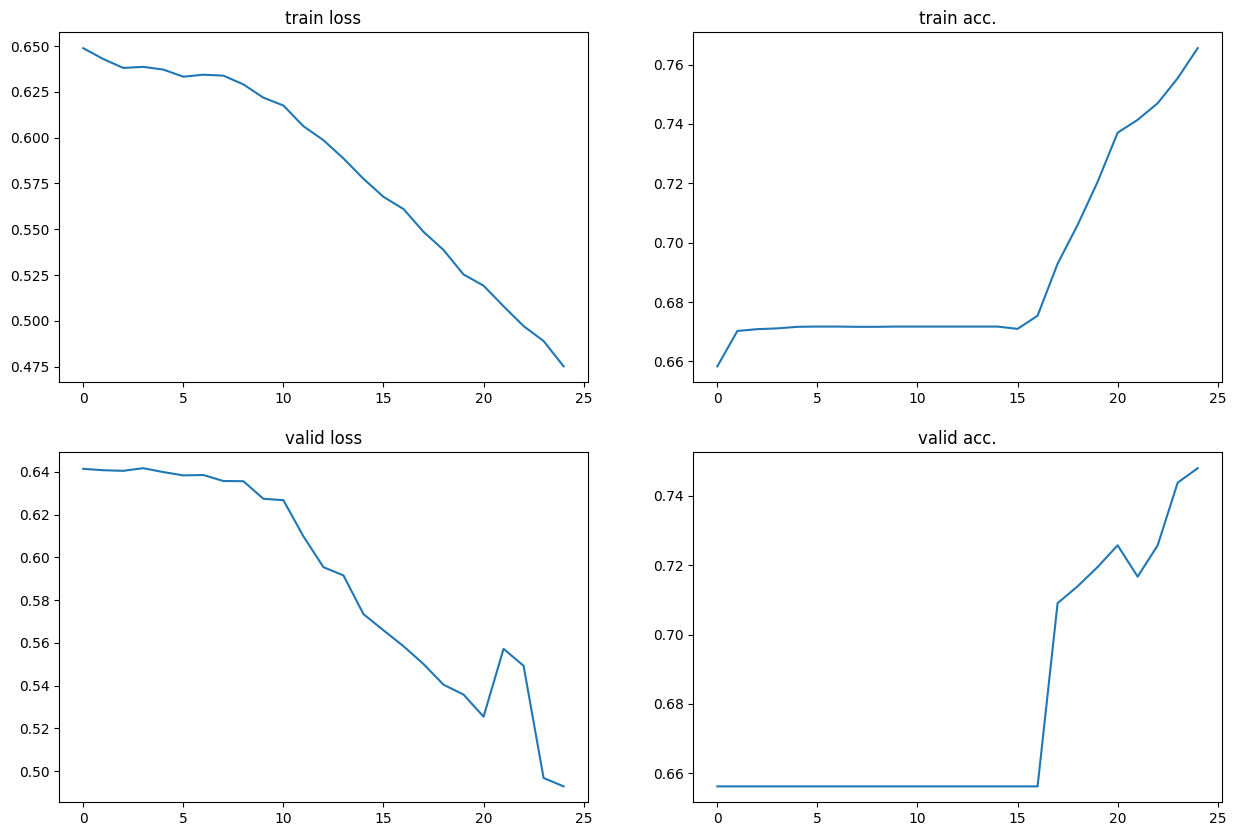

In [16]:
from tqdm import tqdm

epoch_num = 25
train_accs_CE = []
train_losses_CE = []
valid_accs_CE = []
valid_losses_CE = []

train_accs_FO = []
train_losses_FO = []
valid_accs_FO = []
valid_losses_FO = []

fig, axs = plt.subplots(2, 2, figsize=(15,10))
# https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html

for epoch in tqdm(range(epoch_num)):
  # CE loss
  train_loss_CE, train_acc_CE = train_one_epoch(classifier_1, optimizer_1, loss_func_1, train_dataloader)

  valid_loss_CE, val_acc_CE = validate(classifier_1, loss_func_1, val_dataloader)

  print(f"train CE loss: {train_loss_CE:.2f}, valid CE loss: {valid_loss_CE:.2f}")
  print(f"complete_acc CE: {train_acc_CE:.2f}, val_complete_acc CE: {val_acc_CE:.2f}")

  train_losses_CE.append(train_loss_CE)
  train_accs_CE.append(train_acc_CE)

  valid_losses_CE.append(valid_loss_CE)
  valid_accs_CE.append(val_acc_CE)
  # Focal loss
  """train_loss_FO, train_acc_FO = train_one_epoch(classifier_2, optimizer_2, loss_func_2, train_dataloader)

  valid_loss_FO, val_acc_FO = validate(classifier_2, loss_func_2, val_dataloader)

  print(f"train focal loss: {train_loss_FO:.2f}, valid focal loss: {valid_loss_FO:.2f}")
  print(f"complete_acc focal: {train_acc_FO:.2f}, val_complete_acc focal: {val_acc_FO:.2f}")

  train_losses_FO.append(train_loss_FO)
  train_accs_FO.append(train_acc_FO)

  valid_losses_FO.append(valid_loss_FO)
  valid_accs_FO.append(val_acc_FO)"""

axs[0,0].set_title("train loss")
axs[0,0].plot(train_losses_CE)
#axs[0,0].set_title("train loss Focal")
#axs[0,0].plot(train_losses_FO)

axs[0,1].set_title("train acc.")
axs[0,1].plot(train_accs_CE)
#axs[0,1].set_title("train acc. Focal")
#axs[0,1].plot(train_accs_FO)


axs[1,0].set_title("valid loss")
axs[1,0].plot(valid_losses_CE)
#axs[1,0].set_title("valid loss Focal")
#axs[1,0].plot(valid_losses_FO)

axs[1,1].set_title("valid acc.")
axs[1,1].plot(valid_accs_CE)

#axs[1,1].set_title("valid acc. Focal")
#axs[1,1].plot(valid_accs_FO)


In [17]:
torch.save(classifier_1.state_dict(), '/mount/arbeitsdaten/studenten1/team-lab-phonetics/2023/student_directories/tran/CNN_1')
#torch.save(classifier_2.state_dict(), '/mount/arbeitsdaten/studenten1/team-lab-phonetics/2023/student_directories/tran/CNN_2_focal')

### Inference

In [18]:
test_dataset = alc_dataset('/mount/arbeitsdaten/studenten1/team-lab-phonetics/2023/student_directories/tran/teamlab/feature_egemaps_41/test_dict.h5')
test_dataset.max_length = 6170 # maximum feature length 
test_dataset.transform = input_zero_padding_with_length

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(test_dataset)

In [54]:
read_a = ['001','003', '004', '006', '007', '008','009', '011', '012', '013', '015', '016', '017', '019','020','021','023','024','029','030'] #read numbers, address, words, sentences, credit card numbers, auto numbers
spontaneous_a = ['002', '014', '005','010','018'] 
command_control_a = ['022','025','026','027','028'] 

read_na = ['001', '003','004','006','007','008','009','011','012','013','015', '016', '017', '019','020','021','023','024','026','027','028', '031','032','033','035','036','037','039','040','041','044','050','051','052','056','057','058','059','060']
spontaneous_na = ['002','014','022','034', '005', '010', '018','025','030','038'] 
command_control_na = ['042','043','045','046','047','048','049','053','054','055']

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

general_promts = []
promts = []
speakers = []
with open('/mount/arbeitsdaten/studenten1/team-lab-phonetics/2023/student_directories/tran/teamlab/file_name_split/test_list.json','r') as file:
      test_list = json.load(file)
print(f'len test list: {len(test_list)}')
drunk = 0
sober = 0
for name in test_list:
      codes = [x for x in name]
      label = 1 if codes[3] in ['1', '3'] else 0
      promt = ''.join(codes[7:10])
      general_promts.append(promt)
      speaker = ''.join(codes[:3])
      speakers.append(speaker)
      if label == 1:
            drunk += 1
            if promt in read_a:
                  promts.append(0)
            elif promt in spontaneous_a:
                  promts.append(1)
            else:
                  promts.append(2)
      else:
            sober += 1
            if promt in read_na:
                  promts.append(0)
            elif promt in spontaneous_na:
                  promts.append(1)
            else:
                  promts.append(2)

print(drunk)
print(sober)
y_pred =[]
y_true = []
for batch in test_dataloader:

      X = batch[0]
      X[0] = X[0].to(device)
      logits = classifier_1(X) 
      pred = torch.argmax(torch.softmax(logits,1),1)
      y_pred.extend(pred.cpu())
      
      truth = batch[2].to(torch.float32)
      truth_= torch.argmax(truth, dim=1)
      y_true.extend(truth_.cpu())
y_pred = torch.stack(y_pred)
y_true = torch.stack(y_true)

promts = torch.tensor(promts)


correct_idx = torch.argwhere((y_pred==y_true))
wrong_idx = torch.argwhere((y_pred!=y_true))

correct_pr = promts[correct_idx]
wrong_pr = promts[wrong_idx]


print('total promts in test set')
prs, counts = torch.unique(promts, return_counts=True)
# Print the unique values and their corresponding counts
for pr, count in zip(prs, counts):
    print(f"{pr}: {count}")

print('correct classified')
prs, counts = torch.unique(correct_pr, return_counts=True)
# Print the unique values and their corresponding counts
for pr, count in zip(prs, counts):
    print(f"{pr}: {count}")

print('wrongly classified')
prs, counts = torch.unique(wrong_pr, return_counts=True)
# Print the unique values and their corresponding counts
for pr, count in zip(prs, counts):
    print(f"{pr}: {count}")

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(cm)
tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
print(tn)
print(fp)
print(fn)
print(tp)

wrong_idx = wrong_idx.tolist()

len test list: 1436
486
950


/tmp/ipykernel_2859936/2229009202.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return x, torch.tensor(label).to(device), torch.tensor(label_one_hot).to(device)


total promts in test set
0: 963
1: 225
2: 248
correct classified
0: 756
1: 160
2: 200
wrongly classified
0: 207
1: 65
2: 48
[[826 124]
 [196 290]]
826
124
196
290


### Analyse prompts

In [27]:
print(len(general_promts))
promt_list = [general_promts[idx[0]] for idx in wrong_idx]
print(len(promt_list))
promt_dict = {sp: promt_list.count(sp) for sp in set(promt_list)}
print(len(promt_dict))
sorted_dict = dict(sorted(promt_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)

always_correct_promt = [pr for pr in general_promts if pr not in promt_list]
print(set(always_correct_promt))

1436
336
59
{'020': 15, '041': 14, '032': 14, '008': 13, '019': 11, '026': 11, '006': 11, '014': 10, '015': 10, '001': 10, '010': 9, '005': 9, '009': 9, '013': 9, '002': 9, '016': 8, '023': 8, '049': 8, '029': 8, '012': 8, '042': 7, '021': 7, '024': 7, '018': 7, '055': 6, '060': 6, '011': 6, '050': 6, '059': 6, '004': 6, '022': 5, '003': 5, '030': 4, '028': 4, '034': 4, '051': 4, '027': 3, '037': 3, '017': 3, '045': 3, '048': 3, '035': 3, '007': 3, '052': 2, '043': 2, '040': 2, '054': 2, '046': 2, '031': 1, '033': 1, '056': 1, '058': 1, '057': 1, '038': 1, '036': 1, '047': 1, '025': 1, '044': 1, '039': 1}
{'053'}


### Analyse speakers

In [28]:
# see speakers got wrong
speakers_list = [speakers[idx[0]] for idx in wrong_idx]
speaker_dict = {sp: speakers_list.count(sp) for sp in set(speakers_list)}
sorted_dict = dict(sorted(speaker_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)
always_correct_speakers = [sp for sp in speakers if sp not in speakers_list]
print(len(set(always_correct_speakers)))
always_correct_speakers_dict = {sp:always_correct_speakers.count(sp) for sp in set(always_correct_speakers)}
print(always_correct_speakers_dict)

{'042': 7, '595': 7, '049': 7, '053': 7, '581': 6, '569': 6, '079': 5, '590': 5, '099': 5, '054': 5, '576': 5, '009': 5, '561': 5, '102': 5, '507': 5, '048': 5, '019': 5, '589': 5, '031': 4, '017': 4, '563': 4, '568': 4, '018': 4, '046': 4, '095': 4, '047': 4, '594': 4, '522': 4, '087': 4, '086': 4, '064': 4, '586': 4, '556': 4, '572': 3, '505': 3, '541': 3, '070': 3, '058': 3, '011': 3, '596': 3, '523': 3, '547': 3, '008': 3, '069': 3, '526': 3, '092': 3, '090': 3, '089': 3, '545': 3, '025': 3, '078': 3, '578': 3, '055': 2, '520': 2, '565': 2, '555': 2, '036': 2, '518': 2, '562': 2, '587': 2, '032': 2, '550': 2, '029': 2, '091': 2, '082': 2, '022': 2, '575': 2, '560': 2, '080': 2, '050': 2, '100': 2, '570': 2, '097': 2, '532': 2, '585': 2, '028': 2, '065': 2, '591': 2, '051': 2, '557': 2, '088': 2, '573': 2, '525': 2, '096': 2, '544': 2, '081': 2, '074': 2, '582': 1, '536': 1, '584': 1, '072': 1, '546': 1, '071': 1, '023': 1, '094': 1, '060': 1, '024': 1, '509': 1, '062': 1, '558': 1,

### Confusion Matrix

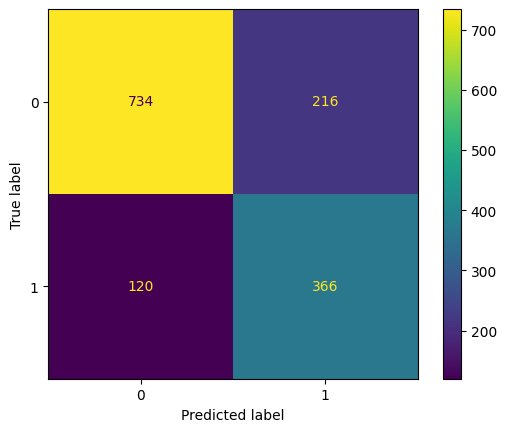

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
#disp.figure_.savefig('confusion_matrix.png')